# Lab Assignment Six: Convolutional Network Architectures



## Dataset Selection

Ships in Satellite Imagery
https://www.kaggle.com/datasets/rhammell/ships-in-satellite-imagery

Group: Nick Benso & Benjamin Kuo

## Preparation (3 points total)  
[1.5 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

[1.5 points] Choose the method you will use for dividi
ng your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 


We chose an image dataset comprised of satalite images of ports that include ships in them, the same as used in lab 2. This dataset for identifying ships can be mainly used to monitor port activity to inform supply chain analyses and potentially port management. As a result, the impact of false negatives or positives are not critical to the application. As a result we will be using accuracy to judge the performance as this will give us a good overall performance metric. However, this data may also potentially be used in military intellegence to to identify movements of military assets or recovery operations to find crashed vehicles like planes or ships. In these cases, it would be important to minimize false negatives and use the recall metric, as having a ship slip by in these cases could lead to insufficient military responses.

In [8]:
from matplotlib import pyplot as plt
from sklearn import metrics as mt
from ipywidgets import widgets
from skimage import color
from skimage import io
from imutils import paths
from sklearn.utils import shuffle
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import os


tf.random.set_seed(2)
np.random.seed(0) # using this to help make results reproducible
tf.config.list_physical_devices('GPU')

dir_path = r"C:\Users\nicho\Downloads\Garbage classification\\"

def loadImg(dir, imgFile):
    img = io.imread(dir + imgFile)
    return color.rgb2gray(img)

def filenameParse(filename):
    repl_delim = '__'
    str = filename.replace(".png", repl_delim)
    return str.split('__')

In [9]:
tf.config.list_physical_devices('GPU')

[]

In [10]:
classes = os.listdir(dir_path)
print(classes)

target_size = (64, 64)
waste_labels = {"cardboard":0, "glass":1, "metal":2, "paper":3, "plastic":4, "trash":5}
    
def load_dataset(path):
  x = []
  labels = []
  image_paths = sorted(list(paths.list_images(path)))
  for image_path in image_paths:
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    x.append(img)
    label = image_path.split(os.path.sep)[-2]
    labels.append(waste_labels[label])
  x, labels = shuffle(x, labels, random_state=42)
  input_shape = (np.array(x[0]).shape[1], np.array(x[0]).shape[1], 3)
  print("X shape: ", np.array(x).shape)
  print(f"Number of Labels: {len(np.unique(labels))} , Number of Observations: {len(labels)}")
  print("Input Shape: ", input_shape)
  x = np.asarray(x)
  return x, labels, input_shape

x, labels, input_shape = load_dataset(dir_path)
h, w, _ = input_shape



['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
X shape:  (2527, 64, 64, 3)
Number of Labels: 6 , Number of Observations: 2527
Input Shape:  (64, 64, 3)


In [11]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, Input
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomRotation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import average 
from tensorflow.keras.models import  Model
from sklearn.model_selection import StratifiedKFold

X = np.array(x)
X = X.astype(np.float32)/16.0 - 0.5
X = X.reshape((X.shape[0],64,64,3))
y = np.array(labels)
y = y.astype(np.int32)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    
    
img_wh = 64
NUM_CLASSES = 6
    
y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

## Modeling (6 points total)
[1.5 points]  Setup the training to use data expansion in Keras (also called data augmentation). Explain why the chosen data expansion techniques are appropriate for your dataset. You can use the keras ImageGenerator as a pre-processing step OR in the optimization loop. You can also use the Keras-cv augmenter (a separate package: https://keras.io/keras_cv/Links to an external site.)

[2 points] Create a convolutional neural network to use on your data using Keras. Investigate at least two different convolutional network architectures (and investigate changing some parameters of each architecture such as the number of filters--at minimum have two variations of each network for a total of four models trained). Use the method of train/test splitting and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras). Be sure that models converge.

[1.5 points] Visualize the final results of the CNNs and interpret/compare the performances. Use proper statistics as appropriate, especially for comparing models. 

[1 points] Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve. Use proper statistical comparison techniques.  


In [12]:
labels = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]
def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = np.argmax(net.predict(X_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels,yticklabels=labels)
    plt.title(title_text+'{:.4f}'.format(acc))

In [13]:
def compare_mlp_cnn(cnn, mlp, X_test, y_test, labels='auto'):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(X_test), axis=1)
        acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
        plt.title('CNN: '+str(acc_cnn))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f',xticklabels=labels,yticklabels=labels)
        plt.title('MLP: '+str(acc_mlp))

In [14]:
from keras.preprocessing.image import ImageDataGenerator
    
datagen = ImageDataGenerator(
     featurewise_center=False,
     samplewise_center=False,
     featurewise_std_normalization=False,
     samplewise_std_normalization=False,
     zca_whitening=False,
     rotation_range=5, # used, Int. Degree range for random rotations.
     width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
     height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
     shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
     zoom_range=0.,
     channel_shift_range=0.,
     fill_mode='nearest',
     cval=0.,
     horizontal_flip=False,
     vertical_flip=False,
     rescale=None)

datagen.fit(X_train)

idx = 0

## CNN Using Expansion Model 1

In [ ]:
%%time 

cnn = Sequential()

# let's start with an AlexNet style convolutional phase
cnn.add(Conv2D(filters=32,
                input_shape = (img_wh,img_wh,3),
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax

# no max pool before next conv layer!!
cnn.add(Conv2D(filters=64,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax
cnn.add(MaxPooling2D(pool_size=(2, 2)))
    

# add one layer on flattened output
cnn.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn.add(Dense(NUM_CLASSES, activation='softmax'))

# Let's train the model 
cnn.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

# the flow method yields batches of images indefinitely, with the given transformations
history = cnn.fit(X_train, y_train_ohe, batch_size=32, 
                   epochs=30, verbose=1,
                   validation_data=(X_test,y_test_ohe)
                  )

In [ ]:
summarize_net(cnn, X_test, y_test, title_text = 'Using Expansion ')

In [ ]:
%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')

## CNN Using Expansion Model 2

The parameter we changed is the batch size, doubling it from 32 to 64

In [ ]:
%%time 

cnn = Sequential()

# let's start with an AlexNet style convolutional phase
cnn.add(Conv2D(filters=32,
                input_shape = (img_wh,img_wh,3),
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax

# no max pool before next conv layer!!
cnn.add(Conv2D(filters=64,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax
cnn.add(MaxPooling2D(pool_size=(2, 2)))
    

# add one layer on flattened output
cnn.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn.add(Dense(NUM_CLASSES, activation='softmax'))

# Let's train the model 
cnn.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

# the flow method yields batches of images indefinitely, with the given transformations
history = cnn.fit(X_train, y_train_ohe, batch_size=64, 
                   epochs=30, verbose=1,
                   validation_data=(X_test,y_test_ohe)
                  )

In [ ]:
summarize_net(cnn, X_test, y_test, title_text = 'Using Expansion ')

In [ ]:
%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')

## CNN Using ResNet Style Blocks Model 1

In [17]:
%%time

# now lets use the LeNet architecture with batch norm
# We will also use ReLU where approriate and drop out 
from tensorflow.keras.layers import Add, Input
from tensorflow.keras.layers import average, concatenate
from tensorflow.keras.models import Model

l2_lambda = 0.0001
input_holder = Input(shape=(img_wh, img_wh, 3))

# start with a conv layer
x = Conv2D(filters=32,
               input_shape = (img_wh,img_wh,3),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(input_holder)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=64,
               kernel_size=(1,1),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x_split)

x = Conv2D(filters=64,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(1,1),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

# now add back in the split layer, x_split (residual added in)
x = Add()([x, x_split])
x = Activation("relu")(x)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256)(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES)(x)
x = Activation('softmax')(x)

resnet = Model(inputs=input_holder,outputs=x)

resnet.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

history = resnet.fit(X_train, y_train_ohe, batch_size=128, 
                      epochs=50, verbose=1,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                     )

Epoch 1/50
18/18 [==============================] - 5s 219ms/step - loss: 13.8851 - accuracy: 0.2004 - val_loss: 1.8328 - val_accuracy: 0.2024
Epoch 2/50
18/18 [==============================] - 4s 203ms/step - loss: 1.8268 - accuracy: 0.2365 - val_loss: 1.6904 - val_accuracy: 0.3452
Epoch 3/50
18/18 [==============================] - 4s 200ms/step - loss: 1.6916 - accuracy: 0.3090 - val_loss: 1.5251 - val_accuracy: 0.4484
Epoch 4/50
18/18 [==============================] - 4s 202ms/step - loss: 1.5508 - accuracy: 0.3811 - val_loss: 1.4193 - val_accuracy: 0.4524
Epoch 5/50
18/18 [==============================] - 4s 199ms/step - loss: 1.5004 - accuracy: 0.4202 - val_loss: 1.3817 - val_accuracy: 0.5079
Epoch 6/50
18/18 [==============================] - 4s 198ms/step - loss: 1.4113 - accuracy: 0.4611 - val_loss: 1.3642 - val_accuracy: 0.4960
Epoch 7/50
18/18 [==============================] - 4s 198ms/step - loss: 1.4008 - accuracy: 0.4673 - val_loss: 1.3560 - val_accuracy: 0.4802
Epoch

8/8 [==============================] - 0s 29ms/step


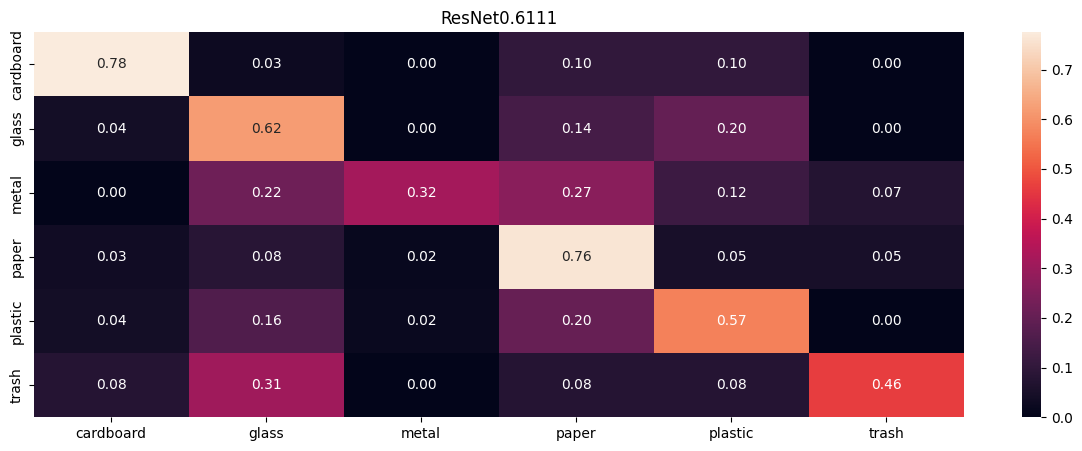

In [18]:
summarize_net(resnet, X_test, y_test, title_text='ResNet')

Text(0.5, 0, 'epochs')

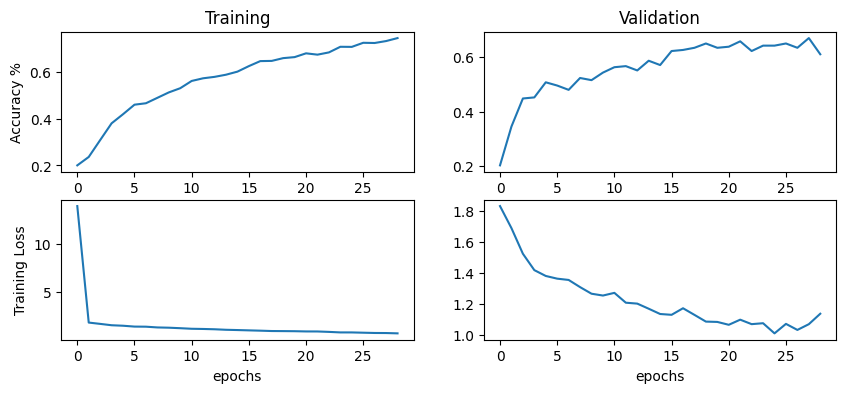

In [19]:
%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')

## CNN Using ResNet Style Blocks Model 2

The parameter we changed is the number of filters, dividing the number filters for each layer by 2

In [ ]:
%%time

# now lets use the LeNet architecture with batch norm
# We will also use ReLU where approriate and drop out 
from tensorflow.keras.layers import Add, Input
from tensorflow.keras.layers import average, concatenate
from tensorflow.keras.models import Model

l2_lambda = 0.0001
input_holder = Input(shape=(img_wh, img_wh, 3))

# start with a conv layer
x = Conv2D(filters=16,
               input_shape = (img_wh,img_wh,3),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(input_holder)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=16,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Conv2D(filters=32,
               kernel_size=(1,1),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x_split)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

x = Conv2D(filters=16,
               kernel_size=(1,1),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', 
               data_format="channels_last")(x)

# now add back in the split layer, x_split (residual added in)
x = Add()([x, x_split])
x = Activation("relu")(x)

x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256)(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES)(x)
x = Activation('softmax')(x)

resnet = Model(inputs=input_holder,outputs=x)

resnet.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
                optimizer='adam', # 'adadelta' 'rmsprop'
                metrics=['accuracy'])

history = resnet.fit(X_train, y_train_ohe, batch_size=128, 
                      epochs=50, verbose=1,
                      validation_data=(X_test,y_test_ohe),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=4)]
                     )

In [ ]:
summarize_net(resnet, X_test, y_test, title_text='ResNet')

In [ ]:
%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')

## MLP 

In [ ]:
# make a 3 layer keras MLP
mlp = Sequential()
mlp.add( Flatten() ) # make images flat for the MLP input
mlp.add( Dense(input_dim=1, units=30, 
               activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

mlp.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

## Exceptional Work (1 points total)
You have free reign to provide additional analyses. 

One idea (required for 7000 level students): Use transfer learning to pre-train the weights of your initial layers of your CNN. Compare the performance when using transfer learning to training without transfer learning (i.e., compare to your best model from above) in terms of classification performance. 